In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb

In [4]:
import os
os.getcwd()

'/Users/nataliamarko/Documents/Kaggle/car_prediction'

In [5]:
train_data = pd.read_csv('/Users/nataliamarko/Documents/Kaggle/car_prediction/train.csv')

In [6]:
train_data.drop('id', inplace=True, axis=1)
train_data.shape

(54273, 12)

In [7]:
train_data.isna().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [8]:
train_data.drop_duplicates()
train_data.shape

(54273, 12)

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54273 entries, 0 to 54272
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         54273 non-null  object
 1   model         54273 non-null  object
 2   model_year    54273 non-null  int64 
 3   milage        54273 non-null  int64 
 4   fuel_type     54273 non-null  object
 5   engine        54273 non-null  object
 6   transmission  54273 non-null  object
 7   ext_col       54273 non-null  object
 8   int_col       54273 non-null  object
 9   accident      54273 non-null  object
 10  clean_title   54273 non-null  object
 11  price         54273 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 5.0+ MB


In [10]:
train_data.T

,0,1,2,3,4,5,6,7,8,9,...,54263,54264,54265,54266,54267,54268,54269,54270,54271,54272
brand,Ford,BMW,Jaguar,BMW,Pontiac,Acura,Audi,GMC,Audi,Acura,...,BMW,Ford,BMW,Honda,Land,BMW,Audi,Porsche,Porsche,Audi
model,F-150 Lariat,335 i,XF Luxury,X7 xDrive40i,Firebird Base,Integra LS,S5 3.0T Prestige,Acadia SLT-1,A3 2.0T Tech Premium,MDX Technology,...,M6 Base,F-150 Lariat,X7 xDrive40i,S2000 Base,Rover Range Rover Sport HST MHEV,X6 xDrive50i,A4 2.0T Premium,Cayenne S,911 Carrera 4 GTS,A5 Sportback S line Premium Plus
model_year,2018,2007,2009,2022,2001,2003,2014,2019,2016,2007,...,2015,2016,2023,2003,2020,2017,2015,2013,2023,2021
milage,74349,80000,91491,2437,111000,124756,107380,51300,87842,152270,...,18651,28000,9200,11563,69000,29000,94634,40989,1518,35000
fuel_type,Gasoline,Gasoline,Gasoline,Hybrid,Gasoline,Gasoline,Gasoline,Gasoline,Gasoline,Gasoline,...,Gasoline,Gasoline,Hybrid,Gasoline,Hybrid,Gasoline,E85 Flex Fuel,Gasoline,Gasoline,Hybrid
engine,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,140.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,193.0HP 2.5L 4 Cylinder Engine Gasoline Fuel,200.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,300.0HP 3.7L V6 Cylinder Engine Gasoline Fuel,...,560.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,440.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,445.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,220.0HP 2.0L 4 Cylinder Engine Flex Fuel Capab...,420.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,4.0L H6 24V GDI DOHC,261.0HP 2.0L 4 Cylinder Engine Gasoline/Mild E...
transmission,10-Speed A/T,6-Speed M/T,6-Speed A/T,Transmission w/Dual Shift Mode,A/T,5-Speed M/T,7-Speed A/T,6-Speed A/T,7-Speed A/T,5-Speed A/T,...,Transmission w/Dual Shift Mode,6-Speed A/T,A/T,5-Speed M/T,Transmission w/Dual Shift Mode,8-Speed A/T,6-Speed A/T,Transmission w/Dual Shift Mode,8-Speed Automatic with Auto-Shift,8-Speed A/T
ext_col,Blue,Black,Purple,Gray,White,Red,Gray,White,Silver,Gray,...,White,Red,White,White,Silver,White,Black,White,Beige,Black
int_col,Gray,Black,Beige,Brown,Black,Beige,Black,Black,Black,Beige,...,Black,Beige,Brown,Black,Black,Brown,Black,Black,Brown,Black
accident,None reported,None reported,None reported,None reported,None reported,At least 1 accident or damage reported,None reported,At least 1 accident or damage reported,None reported,At least 1 accident or damage reported,...,None reported,None reported,At least 1 accident or damage reported,None reported,None reported,None reported,At least 1 accident or damage reported,At least 1 accident or damage reported,None reported,None reported


In [11]:
train_data.describe()

,model_year,milage,price
count,54273.000000,54273.000000,5.427300e+04
mean,2015.091979,72746.175667,3.921844e+04
std,5.588909,50469.490448,7.282634e+04
min,1974.000000,100.000000,2.000000e+03
25%,2012.000000,32268.000000,1.550000e+04
50%,2016.000000,66107.000000,2.800000e+04
75%,2019.000000,102000.000000,4.500000e+04
max,2024.000000,405000.000000,2.954083e+06


In [12]:
df_numeric = train_data.select_dtypes(include='number')
df_categ = train_data.select_dtypes(include=['object'])

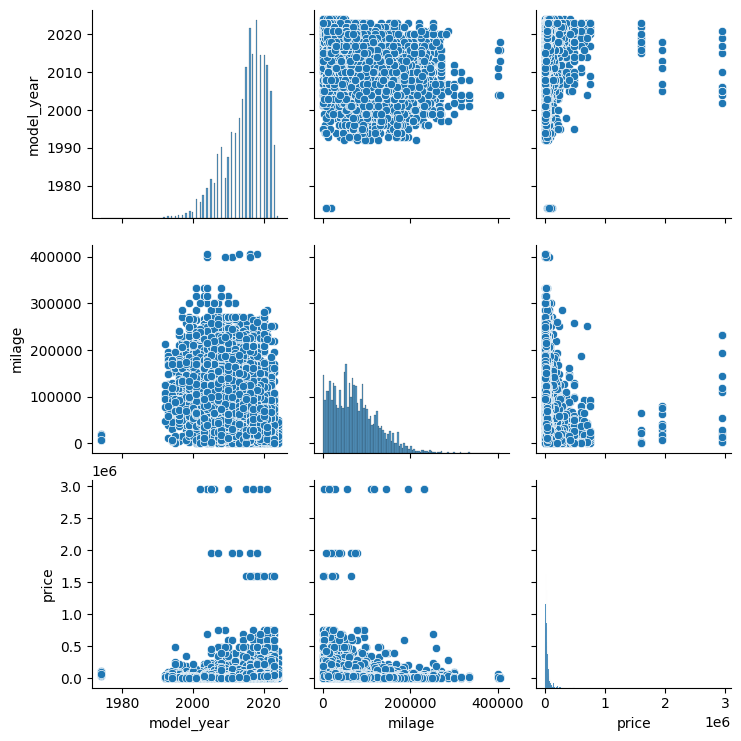

In [13]:
sns_plot = sns.pairplot(train_data[df_numeric.columns.to_list()])

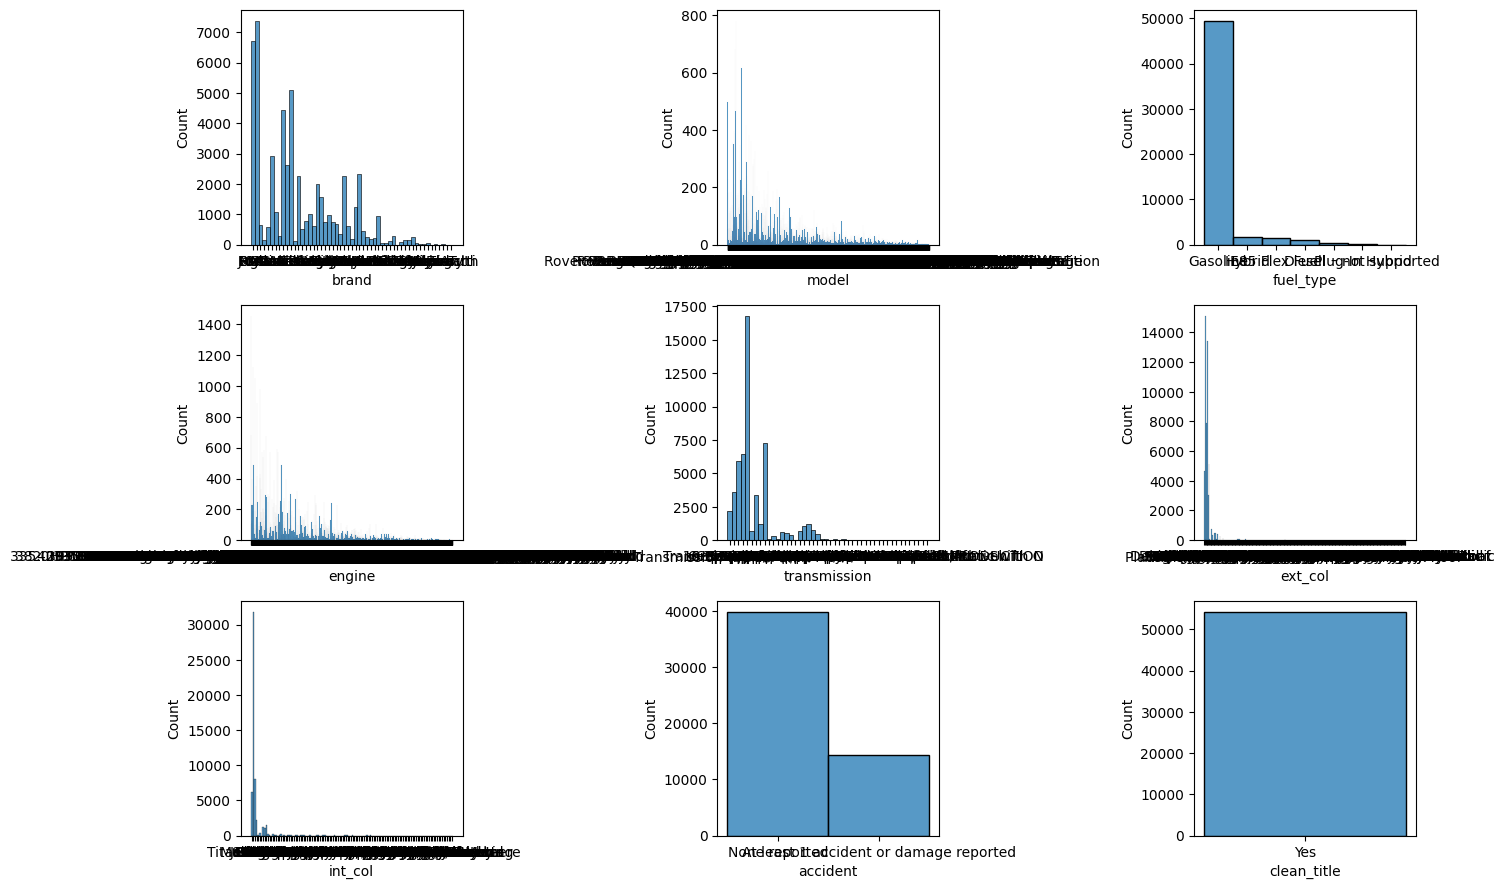

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
cols = df_categ.columns.to_list()

for i, c in enumerate(cols):
    row, col = divmod(i, 3)
    sns.histplot(data=train_data, x=c, ax=axes[row, col])
    
plt.tight_layout()
plt.show()

In [15]:
unique_value_counts = df_categ.nunique()
print(unique_value_counts)

brand             53
model           1827
fuel_type          7
engine          1061
transmission      46
ext_col          260
int_col          124
accident           2
clean_title        1
dtype: int64


In [16]:
df_categ.drop('clean_title', inplace=True, axis=1)

In [17]:
df_categ = pd.get_dummies(df_categ, columns=['accident'], drop_first=True)

In [18]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Create a dictionary to store encoders for each feature
encoders = {}

for column in df_categ.columns:
    unique_value_count = df_categ[column].nunique()
    if 2 < unique_value_count <= 60:
        # One-hot encode for features within the range
        encoder = OneHotEncoder(handle_unknown='ignore')
        encoded_data = encoder.fit_transform(df_categ[[column]])
        encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out([column]))
        df_categ = pd.concat([df_categ, encoded_df], axis=1).drop(column, axis=1)
    else:
        # Label encode for features outside the range
        encoder = LabelEncoder()
        df_categ[column] = encoder.fit_transform(df_categ[column])

    # Store the encoder for later use (e.g., in prediction)
    encoders[column] = encoder


In [19]:
df_categ

,model,engine,ext_col,int_col,accident_None reported,brand_Acura,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,...,transmission_Automatic CVT,transmission_CVT Transmission,transmission_CVT-F,transmission_F,transmission_M/T,transmission_SCHEDULED FOR OR IN PRODUCTION,transmission_Transmission Overdrive Switch,transmission_Transmission w/Dual Shift Mode,transmission_Variable,transmission_–
0,644,719,26,57,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,49,534,17,9,1,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1771,541,181,6,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1748,646,100,24,1,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,693,219,249,9,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54268,1745,856,249,24,1,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54269,165,266,17,9,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54270,421,817,249,9,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
54271,142,762,12,24,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
unique_value_counts = df_numeric.nunique()
print(unique_value_counts)

model_year      34
milage        3212
price         1481
dtype: int64


In [21]:
col_to_transf = 'model_year'
unique_value_model = df_numeric['model_year'].nunique()

encoder = OneHotEncoder(handle_unknown='ignore')
encoded_data = encoder.fit_transform(df_numeric[['model_year']])

encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out([col_to_transf]))
df_numeric.reset_index(drop=True, inplace=True)  # Reset the index before concat

df_numeric = pd.concat([df_numeric, encoded_df], axis=1).drop(col_to_transf, axis=1) # Store the combined dataframe with new name


In [22]:
df_numeric

,milage,price,model_year_1974,model_year_1992,model_year_1993,model_year_1994,model_year_1995,model_year_1996,model_year_1997,model_year_1998,...,model_year_2015,model_year_2016,model_year_2017,model_year_2018,model_year_2019,model_year_2020,model_year_2021,model_year_2022,model_year_2023,model_year_2024
0,74349,11000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,80000,8250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,91491,15000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2437,63500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,111000,7850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54268,29000,29000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54269,94634,6500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54270,40989,18950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54271,1518,194965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [23]:
# Ensure consistent indexes (if needed)
df_categ.reset_index(drop=True, inplace=True)
df_numeric.reset_index(drop=True, inplace=True)

# Concatenate the DataFrames horizontally (along columns)
df_combined = pd.concat([df_numeric, df_categ], axis=1)
df_combined

,milage,price,model_year_1974,model_year_1992,model_year_1993,model_year_1994,model_year_1995,model_year_1996,model_year_1997,model_year_1998,...,transmission_Automatic CVT,transmission_CVT Transmission,transmission_CVT-F,transmission_F,transmission_M/T,transmission_SCHEDULED FOR OR IN PRODUCTION,transmission_Transmission Overdrive Switch,transmission_Transmission w/Dual Shift Mode,transmission_Variable,transmission_–
0,74349,11000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,80000,8250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,91491,15000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2437,63500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,111000,7850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54268,29000,29000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54269,94634,6500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54270,40989,18950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
54271,1518,194965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54273 entries, 0 to 54272
Columns: 147 entries, milage to transmission_–
dtypes: float64(140), int64(7)
memory usage: 60.9 MB


## Lets create a custom preproccessing function

In [26]:
df_train = pd.read_csv('/Users/nataliamarko/Documents/Kaggle/car_prediction/train.csv')

In [27]:
def preprocess_data(df):
    # Drop unnecessary columns
    df = df.drop(columns=['id', 'clean_title'])

    # Separate numeric and categorical features
    df_numeric = df.select_dtypes(include='number')
    df_categ = df.select_dtypes(include=['object'])

    # One-hot encode 'accident' as it's binary
    df_categ = pd.get_dummies(df_categ, columns=['accident'], drop_first=True)

    # Handle other categorical features
    low_cardinality_cols = [col for col in df_categ.columns if 2 < df_categ[col].nunique() <= 60]
    high_cardinality_cols = [col for col in df_categ.columns if df_categ[col].nunique() > 60]
    
    # One-Hot Encode the Low Cardinality columns
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe_df = pd.DataFrame(ohe.fit_transform(df_categ[low_cardinality_cols]), 
                          columns=ohe.get_feature_names_out(low_cardinality_cols))
    df_categ = df_categ.drop(columns=low_cardinality_cols)
    df_categ = pd.concat([df_categ, ohe_df], axis=1)

    # Label Encode the High Cardinality columns
    le = LabelEncoder()
    for col in high_cardinality_cols:
        df_categ[col] = le.fit_transform(df_categ[col])
    
    # One-hot encode 'model_year'
    ohe_model_year = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe_model_year_df = pd.DataFrame(ohe_model_year.fit_transform(df_numeric[['model_year']]),
                                    columns=ohe_model_year.get_feature_names_out(['model_year']))
    df_numeric = df_numeric.drop(columns=['model_year'])
    df_numeric = pd.concat([df_numeric, ohe_model_year_df], axis=1)
   
    # Combine all features
    df_combined = pd.concat([df_numeric, df_categ], axis=1)

    # Standardize numerical features
    #scaler = StandardScaler()
    #df_combined[df_numeric.columns] = scaler.fit_transform(df_combined[df_numeric.columns])

    return df_combined


In [28]:
target = df_train['price']
y = np.log(target)
df_train_pp = preprocess_data(df_train)
X = df_train_pp.drop('price', axis=1)

In [29]:
df_train = pd.read_csv('/Users/nataliamarko/Documents/Kaggle/car_prediction/train.csv')
df_test = pd.read_csv('/Users/nataliamarko/Documents/Kaggle/car_prediction/test.csv')

# Store test IDs separately before preprocessing
test_ids = df_test['id'].copy()  # Make a copy to avoid modifying original df_test
df_test.drop(columns=['id'], inplace=True)

# 2. Concatenate Training and Testing Data (without test IDs)
df_combined = pd.concat([df_train, df_test], ignore_index=True)

# Add a column to identify the origin (train or test)
df_train['dataset_type'] = 'train'
df_test['dataset_type'] = 'test'

# 2. Concatenate Training and Testing Data
df_combined = pd.concat([df_train, df_test], ignore_index=True)
    
# 3. Preprocess Combined Data
X = preprocess_data(df_combined.drop('price', axis=1))  # Preprocess features
y = np.log(df_combined[df_combined['dataset_type'] == 'train']['price'])  # Log-transform the target variable

# 4. Split back into training and testing sets
X_train = X[df_combined['dataset_type'] == 'train']
X_test = X[df_combined['dataset_type'] == 'test']

# Remove the 'dataset_type' column before proceeding to train your model
train_data = X_train.drop('dataset_type', axis=1)
test_data = X_test.drop('dataset_type', axis=1)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2, random_state=42)

# Define the regression models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),  # You can adjust the alpha parameter
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(force_row_wise=True, random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics on the original (non-log) scale
    y_pred_original = np.exp(y_pred)  # Convert predictions back to original scale
    y_test_original = np.exp(y_test)   # Convert true values back to original scale

    rmse = mean_squared_error(y_test_original, y_pred_original, squared=False)  # RMSE on original scale
    r2 = r2_score(y_test_original, y_pred_original)

    results[name] = {'RMSE': rmse, 'R-squared': r2}

# Display the results
results_df = pd.DataFrame(results).T
print(results_df)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1253
[LightGBM] [Info] Number of data points in the train set: 43418, number of used features: 115
[LightGBM] [Info] Start training from score 10.190376
                           RMSE  R-squared
Linear Regression  48749.664672   0.191244
Ridge Regression   48685.078211   0.193386
Random Forest      48369.361145   0.203813
XGBoost            47632.183525   0.227897
LightGBM           47940.149412   0.217881


In [31]:
xgb_model = xgb.XGBRegressor(random_state=42)
lgbm_model = lgb.LGBMRegressor(force_row_wise=True, random_state=42)

xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Prediction (using scaled data)
y_pred_xgb = np.exp(xgb_model.predict(X_test)) 
y_pred_lgbm = np.exp(lgbm_model.predict(X_test))

# Ensemble Weights
w1 = 0.6  # Weight for XGBoost
w2 = 0.4  # Weight for LightGBM

# Weighted Average Prediction
y_pred_weighted = w1 * y_pred_xgb + w2 * y_pred_lgbm

# Evaluate Ensemble Model
rmse_weighted = mean_squared_error(y_test_original, y_pred_weighted, squared=False)
r2_weighted = r2_score(y_test_original, y_pred_weighted)
print('Weighted Averaging Ensemble - RMSE:', rmse_weighted, 'R-squared:', r2_weighted)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1253
[LightGBM] [Info] Number of data points in the train set: 43418, number of used features: 115
[LightGBM] [Info] Start training from score 10.190376
Weighted Averaging Ensemble - RMSE: 47611.87117804035 R-squared: 0.22855544079971712


In [32]:
X_test = test_data

y_pred_xgb = np.exp(xgb_model.predict(X_test)) 
y_pred_lgbm = np.exp(lgbm_model.predict(X_test))

# Weighted Average Prediction
y_pred_weighted = w1 * y_pred_xgb + w2 * y_pred_lgbm

In [33]:
sample = pd.read_csv('/Users/nataliamarko/Documents/Kaggle/car_prediction/sample_submission.csv')
sample

,id,price
0,54273,39218.443
1,54274,39218.443
2,54275,39218.443
3,54276,39218.443
4,54277,39218.443
...,...,...
36178,90451,39218.443
36179,90452,39218.443
36180,90453,39218.443
36181,90454,39218.443


In [34]:
predictions = pd.DataFrame({'id': test_ids, 'price': y_pred_weighted}) 
predictions.to_csv('submission.csv', index=False)

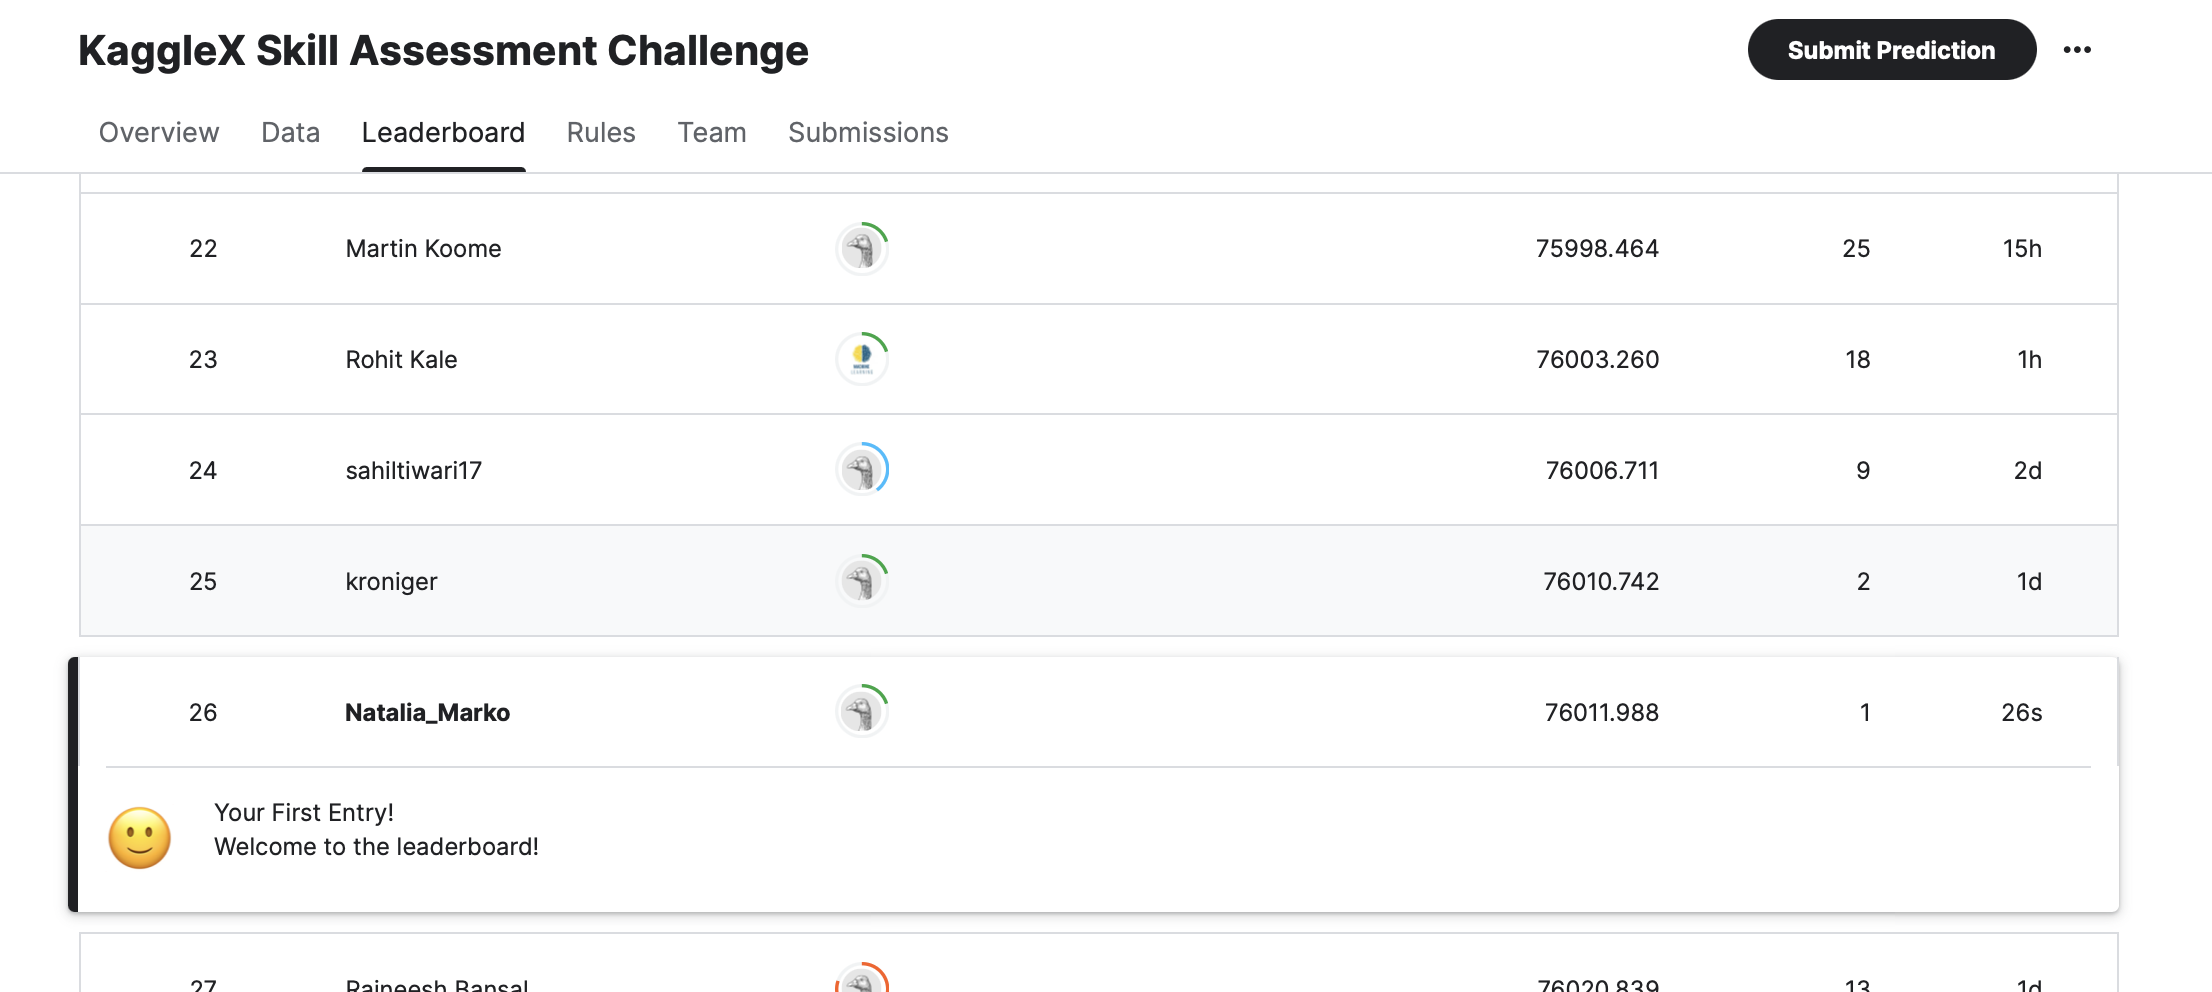